# Laboratorium 8 - Uczenie głębokie - klasyfikacja, kontynuacja
## Techniki Obrazowania Medycznego - AGH 
**Kontakt: wodzinski@agh.edu.pl / MSTeams**


W trakcie laboratorium dokonamy rozszerzenia skryptu z Laboratorium 5 w taki sposób, aby uwzględniał on dodatkowe zagadnienia związane z uczeniem głębokim, tj.:
<ul>
<li> Augmentacja zbioru treningowego, </li>
<li> Wykorzystanie gotowych sieci wytrenowanych na innym, większym zbiorze danych, czyli tzw. transfer learning (na przykładzie ImageNet), </li>
<li> Logowanie treningu sieci za pomocą Tensorboarda, </li>
<li> Interpretowalność uzyskiwanych wyników wykorzystując algorytm GradCAM, </li>
</ul>

Laboratorium można podzielić na następujące części:
<ul>
<li> Utworzenie plików .csv dla zbioru treningowego, walidacyjnego i testowego, </li>
<li> Implementacja dedykowanego dataloadera, </li>
<li> Wczytanie gotowej sieci konwolucyjnej wytrenowanej wstępnie na zbiorze ImageNet, </li>
<li> Dokonanie finetuningu wczytanej sieci neuronowej do danych z Laboratorium 5, logowanie treningu z wykorzystaniem TensorBoard, zapis stanu modelu, </li>
<li> Wczytanie zapisanej sieci, analiza uzyskanych wyników na zbiorze testowym, próba interpretacji wyników korzystając z algorytmu GradCAM, </li>
</ul>


## Część I - Utworzenie plików .csv, podział zbiorów

Podobnie jak na Laboratorium 5 korzystamy z zbioru dostępnego na: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download
Charakterystyka zbioru danych pozostaje niezmieniona.

Zbiór został wstępnie podzielony na zbiór treningowy oraz testowy. Dokonajmy wyróżnienia na zbiór walidacyjny oraz utwórzmy odpowiednie pliki .csv.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.7 MB/s 


In [4]:
import os
import random
import numpy as np
import pandas as pd
import torch as tc
import torchvision as tv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torchvision as tv

import torchvision.models as models

from torchvision.transforms import ToTensor, Resize, Grayscale, RandomHorizontalFlip, Normalize, GaussianBlur, RandomAffine, Compose, RandomAdjustSharpness

In [5]:
dataset_path = r'/content/drive/My Drive/dat/Dataset1' # Path to the dataset
training_csv_path = os.path.join(dataset_path, "training.csv")
validation_csv_path = os.path.join(dataset_path, "validation.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

classes = os.listdir(os.path.join(dataset_path, "Training"))
print(f"Available classes: {classes}")
classes_dict = {classes[i]: i for i in range(len(classes))}
print(f"Classes dict: {classes_dict}") # Mapowanie nazwy klasy do liczby

all_training_cases = []
testing_cases = []
for current_class in classes:
    for current_case in os.listdir(os.path.join(dataset_path, "Training", current_class)):
        case_path = os.path.join(current_class, current_case)
        case_class = classes_dict[current_class]
        all_training_cases.append((case_path, case_class, current_class))
    for current_case in os.listdir(os.path.join(dataset_path, "Testing", current_class)):
        case_path = os.path.join(current_class, current_case)
        case_class = classes_dict[current_class]
        testing_cases.append((case_path, case_class, current_class))

random.shuffle(all_training_cases)
split_ratio = 0.9
training_cases = all_training_cases[:int(len(all_training_cases)*split_ratio)]
validation_cases = all_training_cases[int(len(all_training_cases)*split_ratio):]

training_dataframe = pd.DataFrame(training_cases, columns=['Image_Path', 'Image_Class_Number', 'Image_Class_Name'])
training_dataframe.to_csv(training_csv_path, index=False)

validation_dataframe = pd.DataFrame(validation_cases, columns=['Image_Path', 'Image_Class_Number', 'Image_Class_Name'])
validation_dataframe.to_csv(validation_csv_path, index=False)

testing_dataframe = pd.DataFrame(testing_cases, columns=['Image_Path', 'Image_Class_Number', 'Image_Class_Name'])
testing_dataframe.to_csv(testing_csv_path, index=False)

Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


## Część II - Utworzenie dedykowanego dataloadera

W kolejnym kroku nastąpi implementacja dedykowanego dataloadera. Schemat działania analogiczny do Laboratorium 6 / Laboratorium 7.

Istotna zmiana: Poza implementacją augmentacji w parametrze transforms dokonaj niezależnie wywołania funkcji: tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) (gdy z_norm == True)
Wynika to z faktu, że w dalszej części zajęć będziemy wykorzystywać sieć wytrenowaną na danych, które były trenowane z powyższymi parametrami normalizacji typu Z.

In [29]:
class BrainDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.dataframe = pd.read_csv(self.csv_path)
        self.transforms = transforms # Dodatkowe transformacje do online augmentation
        self.z_norm = z_norm # Czy chcemy dokonac normalizacji typu Z

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        current_path = os.path.join(self.dataset_path, current_case['Image_Path'])
        current_class = current_case['Image_Class_Number']
        current_image = sitk.GetArrayFromImage(sitk.ReadImage(current_path)).astype("float32")

        # Dokonaj kolejno: konwersji na Tensor, interpolacji do rozmiaru 224x224, 
        #konwersji do skali szarości, normalizacji, transformacji (z self.transforms) 
        #i normalizacji typu z (jeżeli self.z_norm == True)

        current_image = (current_image - np.min(current_image)) / (np.max(current_image) - np.min(current_image))
        current_image = ToTensor()(current_image)
        current_image = Grayscale(1)(current_image)
        current_image = Resize((224,224))(current_image)

        current_image = tc.cat([current_image, current_image, current_image], dim=0)

        # TODO
        if self.transforms is not None:
          current_image = Compose(self.transforms)(current_image)

        if self.z_norm:
            current_image = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(current_image)
            

        return current_image, current_class

Podobnie jak w czasie Laboratorium 5, dokonajmy wizualizacji danych treningowych, jednak tym razem bez oraz z wykorzystaniem przykładowych metod augmentacji.

Augmentacja ma na celu syntetyczne zwiększenie zbioru treningowego przez zadawanie losowych transformacji geometrycznych, transformacji intensywności, bądź bardziej skomplikowanych metod opartych na sieciach generatywnych. Syntetyczne zwiększanie i różnicowanie zbioru treningowego zazwyczaj pomaga w obniżeniu skali zjawiska overfittingu do danych treningowych oraz zwiększa zdolność do generalizacji, chociaż należy pamiętać, że dużo zależy od sposobu augmentacji i samego charakteru danych.

Metody augmentacji można podzielić na tzw. metody online i offline, czyli metody stosowane bezpośrednio w trakcie wczytywania danych (dzisiejsze zajęcia) oraz metody stosowane przed rozpoczęciem treningu (poza tematyką przedmiotu).

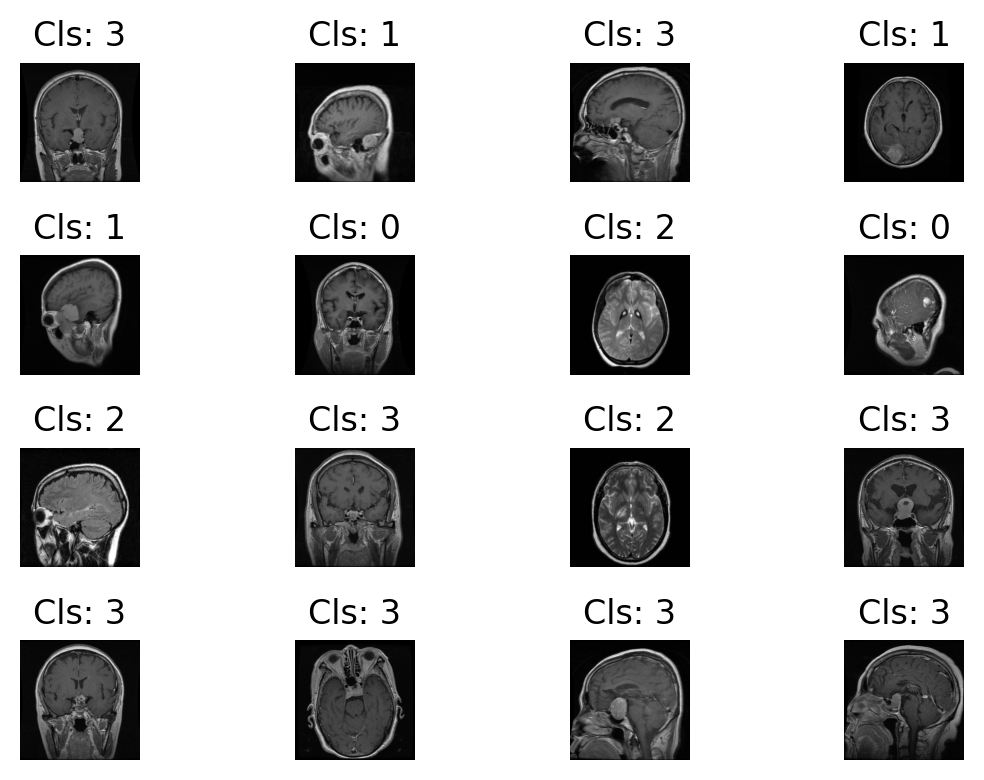

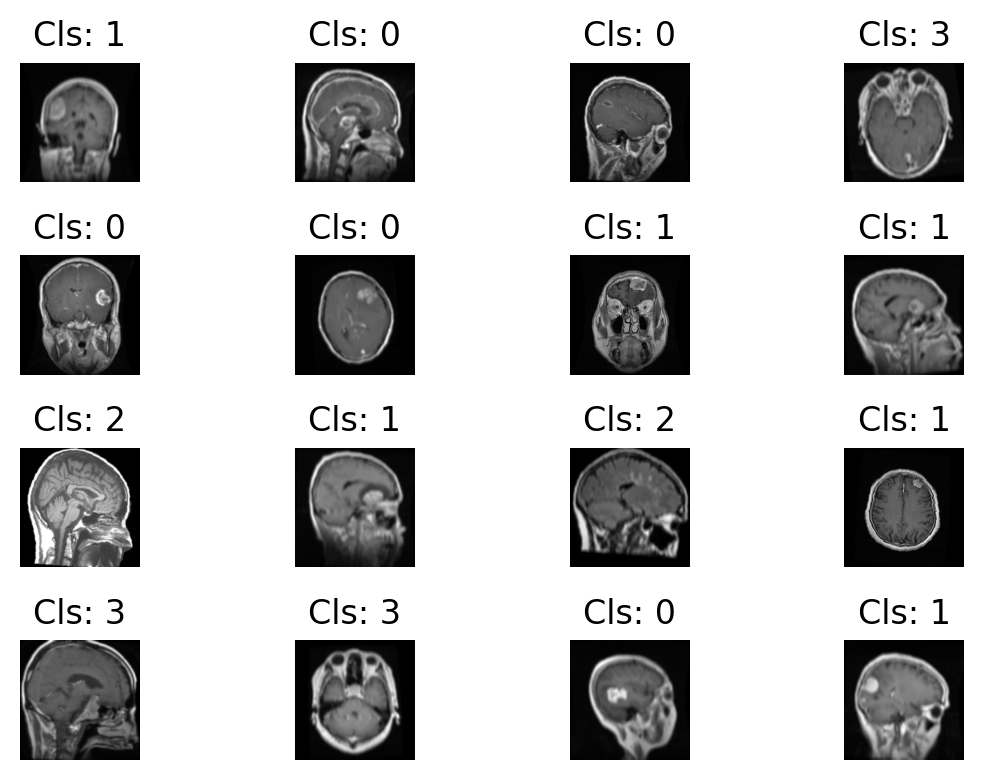

In [32]:
batch_size = 16
shuffle = True
training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

### Przykladowa augmentacja z wykorzystaniem torchvision, opcjonalnie mozna rowniez uzyc albumentations lub torchio
# Utwórz transformacje, która będzie kolejno: 1) Dokonywać horizontal flipu, transformacji afinicznej, 
#rozmycia guassowskiego, losowego zwiększania ostrości
#compose()
transforms = [RandomHorizontalFlip(p=1), 
              RandomAffine(degrees=5),
              GaussianBlur(kernel_size = (5, 9), sigma = (0.1, 5)), 
              RandomAdjustSharpness(sharpness_factor=2)
              ] # TODO

training_dataset_with_augmentation = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path, transforms=transforms)
training_dataloader_with_augmentation = tc.utils.data.DataLoader(training_dataset_with_augmentation, batch_size=batch_size, shuffle=shuffle)

# Visualization without augmentation
for images, classes in training_dataloader:
    rows = 4
    cols = 4
    plt.figure(dpi=200)
    for current_image in range(len(images)):
      plt.subplot(rows, cols, current_image + 1)
      plt.imshow(images[current_image][0].squeeze(), cmap='gray')
      plt.title(f"Cls: {classes[current_image]}")
      plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

# Visualization with augmentation
for images, classes in training_dataloader_with_augmentation:
    rows = 4
    cols = 4
    plt.figure(dpi=200)
    for current_image in range(len(images)):
      plt.subplot(rows, cols, current_image + 1)
      plt.imshow(images[current_image][0].squeeze(), cmap='gray')
      plt.title(f"Cls: {classes[current_image]}")
      plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

## Część III - Wykorzystanie gotowej sieci głębokiej

Bardzo często w praktyce nie implementuje się sieci neuronowych "od zera". Powodów jest wiele:
<ul>
<li> Trenowanie sieci neuronowej o dużej liczbie parametrów jest czasochłonne. </li>
<li> Trenowanie sieci wymaga sporych nakładów energetycznych. Sieci trenowane do tej pory na zajęciach są względnie małe i nie wymagają dużych nakładów obliczeniowych.
Jednak rzeczywiste sieci, szczególnie sieci dedykowane do przetwarzania języka naturalnego, mają biliony parametrów i trenowane są z wykorzystaniem klastrów GPU o
mocy przekraczającej dziesiątki/setki kW. Przeprowadzenie jednego eksperymentu dla takiej sieci to koszty liczone w dziesiątkach tysięcy USD.  </li>
<li> Bardzo często zbiory treningowe (szczególnie w medycynie) nie są na tyle duże by osiągane wyniki w przypadku trenowania "od zera" były satysfakcjonujące.
W tym celu wykorzystuje się gotowe sieci, które ktoś wcześniej wstępnie wytrenował na względnie dużym zbiorze danych (np. ImageNet w przypadku wizji komputerowej).
Następnie, traktuje się taką wytrenowaną sieć jako punkt początkowy do treningu na innym, zdecydowanie mniejszym zbiorze danych. </li>
<li> Projektowanie sieci neuronowej od podstaw wymaga względnie dużej wiedzy o teorii działania sieci neuronowych. Inżynierowie oprogramowania zazwyczaj nie posiadają
odpowiedniej wiedzy/umiejętności i nie są w stanie zaprojektować optymalnej architektury.</li>
</ul>

W kolejnym kroku wykorzystamy sieć ResNet34 wytrenowaną wstępnie na zbiorze ImageNet oraz podmienimy ostatnią warstwę liniową (afiniczną) aby umożliwić klasyfikację na 4 klasy zamiast 1000 jak w przypadku zbioru ImageNet. Następnie zadamy na wejście sieci przykładowe obrazy i zaobserwujemy wyniki.

In [33]:
device = "cuda:0"

model = models.resnet34(pretrained=True) # TODO

model.fc = tc.nn.Linear(512, 4)

model = model.to(device)

"""
Dokonaj wczytania modelu ResNet34 z parametrem pretrained == True, 
podmień ostatnią warstwę na liniową (512 -> 4) i przenieś model na GPU
"""

for images, classes in training_dataloader:
    images = images.to(device)
    output = model(images)
    print(f"Output: {tc.nn.Sigmoid()(output)}")
    print(f"Classes: {classes}")
    break

Output: tensor([[0.4777, 0.3192, 0.3907, 0.4831],
        [0.6677, 0.3038, 0.3616, 0.3718],
        [0.3964, 0.2414, 0.4149, 0.6065],
        [0.6258, 0.4712, 0.2944, 0.5605],
        [0.3865, 0.3251, 0.4646, 0.3326],
        [0.4193, 0.4247, 0.5241, 0.5230],
        [0.5143, 0.5033, 0.3339, 0.5697],
        [0.3996, 0.3486, 0.4291, 0.5638],
        [0.6157, 0.3763, 0.3463, 0.2769],
        [0.6035, 0.4151, 0.1971, 0.4306],
        [0.5301, 0.5583, 0.4810, 0.4599],
        [0.6230, 0.3885, 0.4432, 0.5541],
        [0.4067, 0.3709, 0.3059, 0.4365],
        [0.5099, 0.3898, 0.2030, 0.5947],
        [0.6217, 0.3003, 0.3863, 0.4485],
        [0.4495, 0.4088, 0.4616, 0.4560]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
Classes: tensor([1, 3, 3, 0, 3, 3, 2, 1, 3, 1, 3, 3, 0, 1, 0, 0])


Warto zauważyć, że o tyle ile wyniki działania sieci nie są zgodnę z oczekiwaniami to jednocześnie nie są losowe jak w przypadku Laboratorium 5. Wynika to z faktu, że wszystkie warstwy sieci poza ostatnią (podmienioną po wczytaniu sieci) są wstępnie przetrenowane. W kolejnym kroku przejdziemy do tzw. fine tuningu, czyli dokonamy treningu sieci rozpoczynając od obecnego stanu jako początkowego.

## Część IV - Fine-tuning sieci konwolucyjnej

Pętla treningowa będzie analogiczna do pętli treningowej z Laboratorium 5. Zmiana będzie związana z wykorzystaniem biblioteki Tensorboard do logowania procesu treningu.
Krótkie wprowadzenie do wykorzystania Tensorboarda w PyTorchu można znaleźć na: https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
Umożliwia on bardzo intuicyjną analize procesu treningu bezpośrednio w jego trakcie, oraz łatwe współdzielenie procesu trenowania.

Zdefiniujmy parametry treningu analogiczne do Laboratorium 5:

In [34]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10 # TODO - do testowania dobierz mniejszą liczbe epok
objective_function = tc.nn.CrossEntropyLoss()
parameters = model.parameters()
# TODO - w dalszej części laboratorium (po analizie wyników w części V - 
#dokonaj zamrozenia wag warstw przetrenowanych lub przypisania im mniejszego learning_rate)
#how to decrese neural network layers
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = "cuda:0"

shuffle = True
transforms = [RandomHorizontalFlip(p=1), 
              RandomAffine(degrees=5),
              GaussianBlur(kernel_size = (5, 9), sigma = (0.1, 5)), 
              RandomAdjustSharpness(sharpness_factor=2)
              ]  # TODO - transformacje jak wcześniej

training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path, transforms, z_norm=True)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
validation_dataset = BrainDataset(os.path.join(dataset_path, "Training"), validation_csv_path, None, z_norm=True)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

Następnie zainicjalizujmy Tensorboarda:

In [48]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Następnie zaimplementujmy pętlę treningową. Zauważ, że dzięki Tensorboard wszelka logika związana z manualną wizualizacją procesu treningowego staje się zbędna. W przypadku chęci modyfikacji wizualizacji treningowych można tego dokonać odpowiednio procesując logi Tensorboarda po zakończeniu treningu.

In [36]:
print(f"Training dataset size: {len(training_dataloader.dataset)}")
print(f"Validation dataset size: {len(validation_dataloader.dataset)}")

for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")
    training_loss = 0.0

    model.train()
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device)
        output = model(images)
        loss = objective_function(tc.nn.Sigmoid()(output), classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_loss += loss.item() * images.size(0)
    training_loss = training_loss / len(training_dataloader.dataset)

    writer.add_scalar("Training loss", training_loss, epoch)
    # TODO - lokonaj logowania training_loss wykorzystując writer (Tensorboard)

    validation_loss = 0.0
    model.eval()
    with tc.set_grad_enabled(False):
        for images, classes in validation_dataloader:
            images, classes = images.to(device), classes.to(device)
            output = model(images)
            loss = objective_function(tc.nn.Sigmoid()(output), classes)
            validation_loss += loss.item() * images.size(0)
        validation_loss = validation_loss / len(validation_dataloader.dataset)

        writer.add_scalar("Validation loss", validation_loss, epoch)
        # TODO - lokonaj logowania validation_loss wykorzystując writer (Tensorboard)


Training dataset size: 2583
Validation dataset size: 287
Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9


TensorBoard umożliwia więcej opcji, takich jak logowanie zdjęć, tekstu, zapisywanie parametrów, tworzenie grup eksperymentów do późniejszego porównania.

Finalnie, dokonajmy zapisu stanu modelu do folderu z plikiem notatnika:

In [49]:
writer.flush()
#/content/runs/Jun06_15-04-07_32c513a1ab1e
# TODO - dokonaj zapisu słownika zawierającego wagi modelu do folderu z obecnym skryptem

## Część V - Analiza ilościowa wyników

W kolejnym kroku dokonajmy analogicznej do Laboratorium 5 analizy wyników na wszystkich trzech zbiorach.

In [53]:
batch_size = 16
training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path, None, z_norm=True)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = BrainDataset(os.path.join(dataset_path, "Training"), validation_csv_path, None, z_norm=True)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testing_dataset = BrainDataset(os.path.join(dataset_path, "Testing"), testing_csv_path, None, z_norm=True)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

W pierwszej kolejności utwórz nowy model i dokonaj wczytania stanu modelu po treningu:

In [ ]:
# TODO - utwórz poraz kolejny model i wczytaj jego wcześniej zapisane wagi

#learinig rate na 0?




Using cache found in C:\Users\MW-NPC/.cache\torch\hub\pytorch_vision_v0.10.0


Następnie dokonaj analizy ilościowej analogicznej do Laboratorium 5:

Dataset size: 2583
Training confusion matrix: 
 [[743   3   0   0]
 [ 25 655   4  54]
 [  8   4 327  10]
 [  0   1   0 749]]


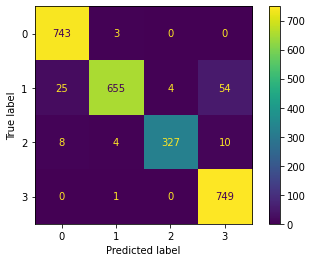

Training classification report: 
               precision    recall  f1-score   support

      Glioma       0.96      1.00      0.98       746
  Meningioma       0.99      0.89      0.94       738
    No_Tumor       0.99      0.94      0.96       349
   Pituitary       0.92      1.00      0.96       750

    accuracy                           0.96      2583
   macro avg       0.96      0.95      0.96      2583
weighted avg       0.96      0.96      0.96      2583



In [50]:
# TODO - dokonaj wizualizacji ilościowej widocznej niżej (analogicznie jak w trakcie Laboratorium 5)

import sklearn.metrics as metrics

predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(training_dataloader.dataset)}")
    for images, classes in training_dataloader:

        images, classes = images.to(device), classes.to(device)
        output = model(images)
        
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)

        predictions.extend(prediction.cpu().numpy().tolist()) 

        targets.extend(classes.cpu().numpy().tolist())


cm = metrics.confusion_matrix(targets, predictions)
print("Training confusion matrix: \n",cm) 

metrics.ConfusionMatrixDisplay(cm).plot()
plt.show()

print("Training classification report: \n", metrics.classification_report(
    targets, predictions, target_names = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]))

Dataset size: 287
Training confusion matrix: 
 [[77  1  0  2]
 [11 59  4 10]
 [ 1  3 41  1]
 [ 4  0  1 72]]


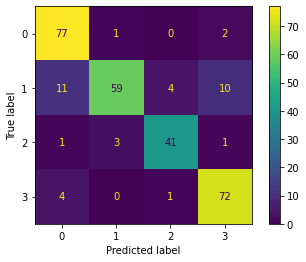

Training classification report: 
               precision    recall  f1-score   support

      Glioma       0.83      0.96      0.89        80
  Meningioma       0.94      0.70      0.80        84
    No_Tumor       0.89      0.89      0.89        46
   Pituitary       0.85      0.94      0.89        77

    accuracy                           0.87       287
   macro avg       0.88      0.87      0.87       287
weighted avg       0.88      0.87      0.86       287



In [51]:
# TODO - dokonaj wizualizacji ilościowej widocznej niżej (analogicznie jak w trakcie Laboratorium 5)

val_predictions = []
val_targets = []
model.eval()

with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(validation_dataloader.dataset)}")
    for images, classes in validation_dataloader:

        images, classes = images.to(device), classes.to(device)
        output = model(images)
        
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)

        val_predictions.extend(prediction.cpu().numpy().tolist()) 

        val_targets.extend(classes.cpu().numpy().tolist())


cm = metrics.confusion_matrix(val_targets, val_predictions)
print("Training confusion matrix: \n",cm) 

metrics.ConfusionMatrixDisplay(cm).plot()
plt.show()

print("Training classification report: \n", metrics.classification_report(
    val_targets, val_predictions, target_names = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]))

In [ ]:
# TODO - dokonaj wizualizacji ilościowej widocznej niżej (analogicznie jak w trakcie Laboratorium 5)

test_predictions = []
test_targets = []
model.eval()

with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(testing_dataloader.dataset)}")
    for images, classes in testing_dataloader:

        images, classes = images.to(device), classes.to(device)
        output = model(images)
        
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)

        test_predictions.extend(prediction.cpu().numpy().tolist()) 

        test_targets.extend(classes.cpu().numpy().tolist())


cm = metrics.confusion_matrix(test_targets, test_predictions)
print("Training confusion matrix: \n",cm) 

metrics.ConfusionMatrixDisplay(cm).plot()
plt.show()

print("Training classification report: \n", metrics.classification_report(
    test_targets, test_predictions, target_names = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]))

Dataset size: 394


Na powyższym widać, że mimo wykorzystania wstępnie wytrenowanej sieci głębokiej oraz podstawowej augmentacji wyniki na zbiorze testowym są bardzo zbliżone do Laboratorium 5 - dlaczego?
Powtórz powyższe eksperymenty wprowadzając dwie zmiany (po zakoćzeniu wizualizacji z wykorzystaniem algorytmu GradCAM - w dalszej cześci zajęć):
<ul>
<li> Porównaj wizualnie dane wejściowe w danych klasach z biorze testowym i zbiorze treningowym (szczególnie dla dwóch klas z problemami). Jakie różnice dostrzegasz? Zaproponuj i wykorzystaj metody augmentacji, które zbliżą przypadki treningowe, do tych widocznych w zbiorze testowym (odpowiednie metody są do znalezienia w bibliotece albumentations).</li>
<li> Uczyliśmy wszystkie warstwy sieci ResNet34 i tym samym po odpowiedniej liczbie epok ponownie uzyskaliśmy "pewnego rodzaju" overfitting (nieobserwowany na zbiorze walidacyjnym). Spróbuj temu zapobiec poprzez ponowienie treningu, jednak tym razem zamrażając (bądź zmniejszając learning_rate) wszystkie warstwy sieci z wyjątkiem warstwy ostatniej. W ten sposób dokonamy treningu tylko ostatniej warstwy afinicznej (bądź wolnego treningu pozostałych), a wszystkie pozostałe wagi przetrenowanej sieci pozostaną bez zmian (lub z wolniejszymi zmianami).</li>
</ul>

Co istotne - w przypadku gdy obserwujemy spadek funkcji kosztu na zbiorze treningowym oraz zbiorze waliacyjnym, a wyniki na zbiorze testowym są niesatysfakcjonujące, wynika to najczęściej z dwóch powodów:
<ul>
<li> Dane ze zbioru walidacyjnego są zbyt podobne do danych treningowych i nie obserwuje się ukrytego overfittingu. </li>
<li> Dane ze zbioru testowego są zbyt różne od danych treningowych i overfitting co prawda nie występuje, ale sieć nie ma zdolności do generalizacji wiedzy na wcześniej niewidziane przypadki. </li>
</ul>

Aby wykryć tego typu zachowanie bezpośrednio w czasie treningu najlepiej - tam gdzie to możliwe - jako zbiór walidacyjny stosować dane z innej dystrybucji (np. innego ośrodka medycznego) niż dokonywać losowego podziału zbioru treningowego.

Na koniec, wykorzystajmy algorytm GradCAM do bardziej intuicyjnej i jakościowej interpretacji wyników.

Algorytm GradCAM służy do wskazania obszarów w obrazie, dla których wartości gradientu w trakcie backpropagacji są wysokie. Algorytm zakłada, że cechy różnicujące w głębszych warstawch są geometrycznie skorelowane z warstwami początkowymi, co nie zawsze jest prawdą, jednak dla wielu zastosowań wystarcza. Taka wizualizacja umożliwia utworzenie mapy kolorów, którą następnie można nałożyć na obraz i określić, które fragmenty obrazu zostały wykorzystane do podjęcia danej decyzji klasyfikacyjnej. GradCAM jest najbardziej podstawowym algorytmem wspierającym interpretowalność wyników uczenia głębokiego, obecnie jest ich zdecydowanie więcej i wyniki bazujące na tzw. self-attention są zazwyczaj zdecydowanie bardziej dokładne.

Poniżej zaimplementowana klasa do wyznaczania odpowiednich odpowiedzi:

In [ ]:
class OurGradCAM(tc.nn.Module):
    def __init__(self, model, layer_name):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.output = None
        
        self.model = model
        to_hook = getattr(self.model, layer_name)
        self.layerhook.append(to_hook.register_forward_hook(self.forward_hook()))
        
        for param in self.model.parameters():
            param.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.output = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.model(x)
        return out, self.output

Wykorzystaj powyższą klasę by dokonać wizualizacji na przykładowych danych z zbioru treningowego (gdzie teoretycznie wyniki klasyfikacji są bardzo dobre). Czy uzyskiwane rezultaty są zgodne z oczekiwaniami? Czy główne miejsca aktywacji są zgodne z położeniem nowotworu w obrazie? Czego tak naprawdę nauczyła się sieć? Czy ilościowa ocena rezultatów w takim przypadku jest wystarczająca? Dokonaj wizualizacji wyników podmieniając "layer4" na kolejno "layer3", "layer2", "layer1". Jak skomentujesz uzyskiwane rezultaty? Co pokazują kolejne warstwy?

Powtórz wszystkie eksperymenty po ponownym wytrenowaniu sieci z bardziej różnorodną augmentacją oraz po zamrożeniu wszystkich warstw z wyjątkiem ostatniej. Jak teraz prezentują się wizualizacje z wykorzystaniem GradCAM?

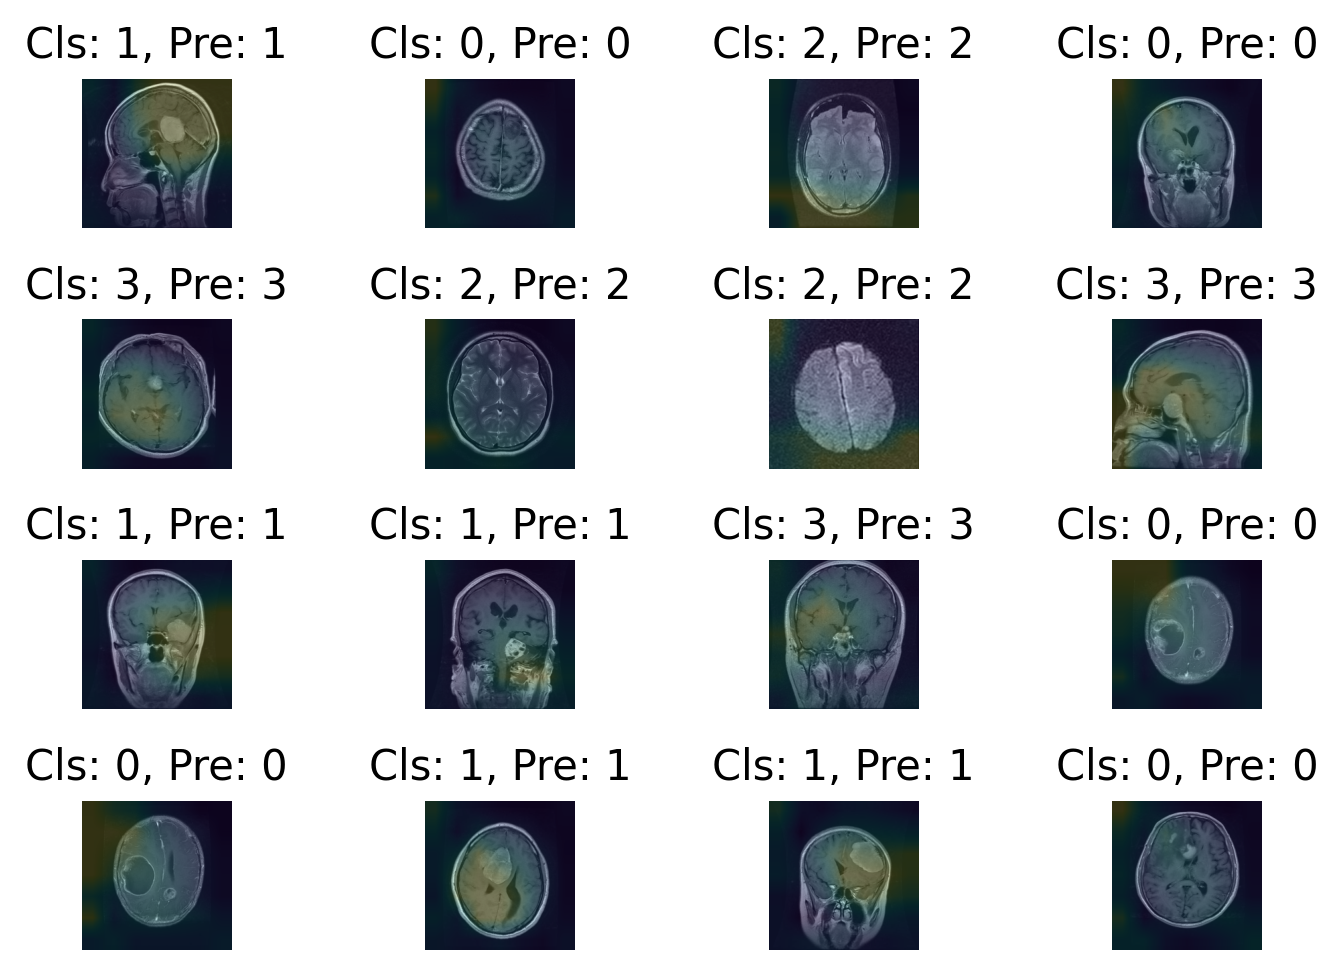

In [ ]:
batch_size = 16
training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path, None, z_norm=True)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_dataset = BrainDataset(os.path.join(dataset_path, "Testing"), testing_csv_path, None, z_norm=True)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

gradcam = OurGradCAM(model, "layer4")
gradcam.model.eval()

for images, classes in training_dataloader:
    images, classes = images.to(device), classes.to(device)
    output, activation = gradcam(images)
    prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)

    activation = activation.detach().cpu()
    loss = objective_function(output, classes)
    loss.backward()

    grads = gradcam.get_act_grads().detach().cpu()
    pooled_grads = tc.mean(grads, dim=[0,2,3]).detach().cpu()
    for i in range(activation.shape[1]):
        activation[:,i,:,:] += pooled_grads[i]
    gradcam_response = tc.mean(activation, dim = 1).squeeze()
    gradcam_response /= gradcam_response.max(axis = 0)[0]
    gradcam_response = tv.transforms.Resize((224, 224))(gradcam_response)

    rows = 4
    cols = 4
    plt.figure(dpi=250)
    for i in range(images.size(0)):
      plt.subplot(rows, cols, i + 1)
      #plt.imshow(incorrect_tuples[0][i].squeeze(), cmap='gray')
      #to_print = f"Pre: {incorrect_tuples[1][i]}, Trg: {incorrect_tuples[2][i]}"
      #plt.title(to_print)
      plt.axis('off')
      
      # TODO - dokonaj wizualizacji widocznej poniżej
    plt.tight_layout()
    plt.show()
    break